In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf
import glob
import numpy as np
from PIL import Image
from sklearn.metrics import pairwise_distances, roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm
import sys
sys.path.append("../")
from inception_resnet_v1 import inference

In [2]:
def prewhiten(x):
    """
    A helper function to whiten an image, or a batch of images.
    Args:
        x: An image or batch of images.
    """
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        print(x.ndim)
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
#     std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    """
    Normalizes an embedding to have unit length in the l2 metric.
    Args:
        x: A batch of numpy embeddings
    """
    output = x / np.sqrt(np.maximum(np.sum(np.square(x),
                                           axis=axis,
                                           keepdims=True),
                                    epsilon))
    return output

In [3]:
class PersonImages:
    def __init__(self, person_name):
        self.clean_folder = ""
        self.clean_images = []
        self.adversarial_images = []
        self.orig_mean = None
        self.orig_std = None
        self.orig_paths = []
        self.person_name = person_name
    
    def _load_one_facenet(self, path, resize_size=None, prewhiten_img=True):
        img = Image.open(path).convert("RGB")
    
            
        if resize_size:
            img = img.resize((resize_size, resize_size))
            
        img = (np.array(img)).astype(np.float32)
        
        if prewhiten_img:
            img = prewhiten(img)
            
        return img
        
    def _load_folder_for_facenet(self, folder, resize_size=None):
        paths_list = glob.glob(os.path.join(folder, "*"))
        final_imgs = []
        for img_path in paths_list:
            final_imgs.append(
                self._load_one_facenet(
                    img_path, prewhiten_img=False, resize_size=resize_size))
        
        final_imgs = np.array(final_imgs)
        mean, std = np.mean(final_imgs), np.std(final_imgs)
        final_imgs = prewhiten(np.array(final_imgs))
        return final_imgs, mean, std, paths_list
        
    def load_clean_from_folder(self, clean_folder, resize_size=160):
        self.clean_folder = clean_folder
        self.clean_images, self.orig_mean, self.orig_std, self.orig_paths = self._load_folder_for_facenet(
            clean_folder, resize_size=resize_size)
    
    def _undo_preprocess(self, images):
        restored_images = images.copy()
        restored_images  *= self.orig_std
        restored_images += self.orig_mean
        restored_images = np.clip(restored_images, 0.0, 255.0)
        return np.uint8(restored_images)
    
    def _compute_embeddings(self, model, images):
        return model.predict(np.array(images), batch_size=len(images))
    
    def get_clean_for_display(self):
        return self._undo_preprocess(self.clean_images)
    
    def compute_clean_embeddings_with_model(self, model):
        self.clean_embeddings = self._compute_embeddings(model, self.clean_images)

In [4]:
class MyModel:
    def __init__(self, model_path, inputs=None, sess=None):
        if inputs is None:
            self.model_inputs = tf.placeholder(tf.float32, shape=(None, 160, 160, 3))
        else:
            self.model_inputs = inputs
        
        vars_before = tf.global_variables()
        self.net, self.endpoints = inference(
            self.model_inputs, keep_probability=1.0, bottleneck_layer_size=512, phase_train=False)
        vars_after = tf.global_variables()
        
        model_name = dataset_to_model_name["vggface2"]
        saver = tf.train.Saver(list(set(vars_after) - set(vars_before)))
        
        if sess is None:
            self.sess = tf.Session()
        else:
            self.sess = sess
            
        saver.restore(self.sess, model_path)
    
    def predict(self, inputs, batch_size):
        return self.sess.run(self.net, feed_dict={self.model_inputs: inputs})
    
    def __del__(self):
        self.sess.close()

dataset_to_model_name = {
    "casia-webface": "20180408-102900",
    "vggface2": "20180402-114759"
}

dataset_to_ckpt_number = {
    "casia-webface": "90",
    "vggface2": "275"
}

def build_model(dataset_name, inputs=None, sess=None):
    model_name = dataset_to_model_name[dataset_name]
    model = MyModel(
        os.path.join(
            "/home/ivan/facenet/models",
            model_name,
            "model-{model_name}.ckpt-{ckpt_num}".format(
                model_name=dataset_to_model_name[dataset_name],
                ckpt_num=dataset_to_ckpt_number[dataset_name]
            )),
        inputs, 
        sess
    )
    return model

In [5]:
def path_for_id_clean(identity):
    if identity == "n000958":
        return "/data/vggface/test_perturbed_sampled/{id}/community_naive_mean/n000029/epsilon_0.0/png".format(id=identity)
    else:
        return "/data/vggface/test_perturbed_sampled/{id}/community_naive_mean/n000958/epsilon_0.0/png".format(id=identity)
    

In [6]:
def build_person(person_name, path_for_id_fn, model=None):
    person_a = PersonImages(person_name)
    person_a.load_clean_from_folder(path_for_id_fn(person_a.person_name))
    if model is not None:
        print("Computing embeddings for", person_name)
        person_a.compute_clean_embeddings_with_model(model)
    return person_a

In [7]:
vggface2_model = build_model("vggface2")
people = [
    build_person(person_name, path_for_id_clean, vggface2_model) \
    for person_name in os.listdir("/data/vggface/test_perturbed_sampled")
]
del vggface2_model

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275
Computing embeddings for n001781
Computing embeddings for n009232
Computing embeddings for n000958
Computing embeddings for n003356
Computing embeddings for n008655
Computing embeddings for n008613
Computing embeddings for n004658
Computing embeddings for n001683
Computing embeddings for n002647
Computing embeddings for n009288
Computing embeddings for n005427
Computing embeddings for n002763
Computing embeddings for n002503
Computing embeddings for n003215
Computing embeddings for n005359
Computing embeddings for n005303
Computing embeddings for n007548
Computing embeddings for n000029
Computing embeddings for n009114


In [8]:
def build_vggface_model(inputs, sess):
    return build_model("vggface2", inputs, sess)

def build_casiawebface_model(inputs, sess):
    return build_model("casia-webface", inputs, sess)

    
def attack_batch(
    build_model_fn, 
    input_images,
    target_vectors,
    learning_rate,
    epsilon,
    max_iters
):
    input_images = np.array(input_images)
    batch_size, orig_h, orig_w, orig_c = input_images.shape
    
    with tf.Graph().as_default():
        with tf.Session() as sess:
            targets_var = tf.get_variable(
                name="targets",
                shape=target_vectors.shape,
            )
            sess.run(tf.assign(targets_var, target_vectors))
            
            noisy_images_var = tf.get_variable(
                name="noisy_images",
                shape=input_images.shape
            )
            sess.run(tf.assign(noisy_images_var, input_images + tf.random.normal(input_images.shape, 0.0, 0.1)))

#             noise_var = tf.get_variable(
#                 name="adversarial_noise",
#                 shape=input_images.shape,
#                 initializer=tf.initializers.truncated_normal(
#                     mean=np.mean(input_images),
#                     std=np.std(input_images)
#                 )
#             )
            
                        
            randomized_images_plus_noise = tf.image.random_brightness(
                    noisy_images_var, 0.5)

            randomized_images_plus_noise = tf.image.random_crop(
                randomized_images_plus_noise, 
                [batch_size, orig_h - 10, orig_w - 10, 3]
            )
            
            randomized_images_plus_noise = tf.image.resize_images(
                randomized_images_plus_noise, [orig_h, orig_w])

            randomized_images_plus_noise += tf.random.normal(
                randomized_images_plus_noise.shape, 0.0, 0.75)
            
            model = build_model_fn(
                inputs=randomized_images_plus_noise, 
                sess=sess
            )
            
            model_outputs = tf.nn.l2_normalize(model.net, axis=0)
            targets = tf.nn.l2_normalize(targets_var, axis=0)
            print("model outputs shape", model_outputs.shape.as_list(), "targets shape", targets.shape.as_list())
            multiplied = tf.multiply(model_outputs, targets)
            print("multiplied shape", multiplied.shape.as_list())
            loss = tf.reduce_sum(multiplied)
            
            losses = []
            for i in range(max_iters):
                grads = tf.gradients(loss, [noisy_images_var])[0]
                assert grads is not None
                losses.append(sess.run(loss))
                sess.run([
                    tf.assign(
                        noisy_images_var,
                        noisy_images_var - learning_rate * tf.sign(grads)
                    ),
                    tf.assign(
                        noisy_images_var, 
                        tf.clip_by_value(
                            noisy_images_var, 
                            input_images - epsilon,
                            input_images + epsilon
                        ))
                ])
            return sess.run(noisy_images_var), losses

In [9]:
def attack_batch_cw(
    build_model_fn, 
    input_images,
    target_vectors,
    learning_rate,
    epsilon,
    max_iters
):
    input_images = np.array(input_images)
    batch_size, orig_h, orig_w, orig_c = input_images.shape
    print("input images mean {mean} and stddev {stddev}".format(mean=np.mean(input_images), stddev=np.std(input_images)))
    with tf.Graph().as_default():
        with tf.Session() as sess:
            targets_var = tf.get_variable(
                name="targets",
                shape=target_vectors.shape,
            )
            sess.run(tf.assign(targets_var, target_vectors))
            
            images_input_ph = tf.placeholder(
                tf.float32,
                name="input_images",
                shape=input_images.shape
            )
            
            noise_var = tf.get_variable(
                name="adversarial_noise",
                shape=input_images.shape,
                initializer=tf.initializers.truncated_normal(
                    mean=np.mean(input_images),
                    stddev=3 * np.std(input_images)
                )
            )
            sess.run(noise_var.initializer)
            
            images_plus_noise = images_input_ph + noise_var

            randomized_images_plus_noise = tf.image.random_brightness(
                images_plus_noise, 0.5)
        
            randomized_images_plus_noise = tf.image.random_crop(
                randomized_images_plus_noise, 
                [batch_size, orig_h - 10, orig_w - 10, 3]
            )

            randomized_images_plus_noise = tf.image.resize_images(
                randomized_images_plus_noise, [orig_h, orig_w])
            
            randomized_images_plus_noise += tf.random.normal(
                randomized_images_plus_noise.shape, 0.0, 0.75)
            
            randomized_images_plus_noise = tf.clip_by_value(
                randomized_images_plus_noise, input_images - epsilon, input_images + epsilon)
            
            model = build_model_fn(
                inputs=randomized_images_plus_noise, 
                sess=sess
            )
            
            model_outputs = tf.nn.l2_normalize(model.net, axis=1)
            targets = tf.nn.l2_normalize(targets_var, axis=1)
            loss = tf.losses.cosine_distance(targets, model_outputs, axis=1)
        
            total_loss = loss + 1e-6 * tf.nn.l2_loss(noise_var)
            
            vars_before = set(tf.global_variables())
            train_op = tf.train.AdamOptimizer(learning_rate).minimize(
                total_loss, var_list=[noise_var])
            vars_after = set(tf.global_variables())
            sess.run([v.initializer for v in list(vars_after - vars_before)])
            
            
            losses = []
            for i in range(max_iters):
                loss_value, total_loss_value, _ = sess.run(
                    [loss, total_loss, train_op], feed_dict={images_input_ph: input_images})
                assert not np.isnan(loss_value), "Loss_value is nan"
                losses.append(loss_value)
            
            final_imgs = sess.run(
                tf.clip_by_value(images_plus_noise, input_images - epsilon, input_images + epsilon),
                feed_dict={images_input_ph: input_images}
            )
            
            return final_imgs, losses

In [10]:
def generate_decoys(
    people_list,
    attack_strategy,
    model_to_attack,
    learning_rate,
    epsilon,
    max_iters
):
    if model_to_attack == "vggface2":
        model_build_fn = build_vggface_model
    elif model_to_attack == "casia-webface":
        model_build_fn = build_casiawebface_model
        
    for person in tqdm(people_list):
        num, height, width, channels = person.clean_images.shape
        person.adversarial_images = np.zeros((2*(len(people_list) - 1), height, width, channels))
        indx = 0
        for other_person in tqdm(people_list):
            if person.person_name == other_person.person_name:
                continue
            target_vector = np.mean(other_person.clean_embeddings, axis=0)
            images_to_make_adversarial = person.clean_images[indx : indx + 2] 
            targets_for_images = np.array([target_vector for _ in range(len(images_to_make_adversarial))])
            person.adversarial_images[indx : indx + 2], losses = attack_batch(
                model_build_fn, 
                images_to_make_adversarial,
                targets_for_images,
                learning_rate,
                epsilon,
                max_iters
            )
            print("Done generating decoys by", person.person_name, "for", other_person.person_name)
            
            fig, ax = fig1, ax1 = plt.subplots()
            ax.plot(range(len(losses)), losses)
            plt.show()
            
            save_dest = os.path.join(
                "/data/vggface/test_perturbed_sampled",
                person.person_name,
                "{attack_strategy}_{model}".format(attack_strategy=attack_strategy, model=model_to_attack),
                other_person.person_name
            )
            
            save_path = os.path.join(save_dest, "epsilon_{}".format(epsilon), "png")
            os.makedirs(save_path, exist_ok=True)
            existing_files = os.listdir(save_path)

            # Clean up folder if need be
            if len(existing_files) > 0:
                for f in existing_files:
                    os.remove(os.path.join(save_path, f))
            
            for i in range(indx, indx + 2):
                orig_name = person.orig_paths[i].split("/")[-1]
                
                full_save_path = os.path.join(save_path, orig_name)
                print("Saving to", save_path)
                Image.fromarray(
                    person._undo_preprocess(person.adversarial_images[i])
                ).save(full_save_path)

            indx += 2

In [11]:
def generate_decoys_bigger_batches(
    people_list,
    attack_strategy,
    model_to_attack,
    learning_rate,
    epsilon,
    max_iters
):
    if model_to_attack == "vggface2":
        model_build_fn = build_vggface_model
    elif model_to_attack == "casia-webface":
        model_build_fn = build_casiawebface_model
        
    for person in tqdm(people_list):
        num, height, width, channels = person.clean_images.shape
        person.adversarial_images = np.zeros((2*(len(people_list) - 1), height, width, channels))
        
        indx = 0
        
        images_to_make_adversarial = []
        targets_for_images = []
        
        for other_person in people_list:
            if person.person_name == other_person.person_name:
                continue
                
            current_chosen_indices = range(indx, indx + 2)
            images_to_make_adversarial.extend(np.take(
                person.clean_images, current_chosen_indices, axis=0))
            
            target_vector = np.mean(other_person.clean_embeddings, axis=0)
            targets_for_images.extend(np.array([
                target_vector for _ in range(len(current_chosen_indices))]))
            
            indx += 2
            
        images_to_make_adversarial = np.array(images_to_make_adversarial)
        
        all_adversarial_images, losses = attack_batch_cw(
            model_build_fn, 
            np.array(images_to_make_adversarial),
            np.array(targets_for_images),
            learning_rate,
            epsilon,
            max_iters
        )
            
        fig, ax = plt.subplots()
        ax.plot(range(len(losses)), losses)
        plt.show()
        
        indx = 0
        for other_person in people_list:
            if person.person_name == other_person.person_name:
                continue
            
            save_dest = os.path.join(
                "/data/vggface/test_perturbed_sampled",
                person.person_name,
                "{attack_strategy}_{model}".format(attack_strategy=attack_strategy, model=model_to_attack),
                other_person.person_name
            )
            
            save_path = os.path.join(save_dest, "epsilon_{}".format(epsilon), "png")
            os.makedirs(save_path, exist_ok=True)
            existing_files = os.listdir(save_path)

            # Clean up folder if need be
            if len(existing_files) > 0:
                for f in existing_files:
                    os.remove(os.path.join(save_path, f))
            
            for i in range(indx, indx + 2):
                orig_name = person.orig_paths[i].split("/")[-1]
                person.adversarial_images[i] = all_adversarial_images[i]
                full_save_path = os.path.join(save_path, orig_name)
                print("Saving to", save_path)
                Image.fromarray(
                    person._undo_preprocess(person.adversarial_images[i])
                ).save(full_save_path)

            indx += 2

  0%|          | 0/19 [00:00<?, ?it/s]

input images mean 9.97825910786787e-09 and stddev 1.0000001192092896
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275


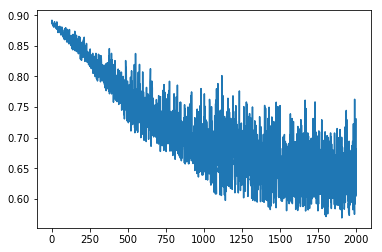

Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n

  5%|▌         | 1/19 [03:34<1:04:16, 214.22s/it]

Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n002763/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n002503/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n002503/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001781/mean_vggface2/n

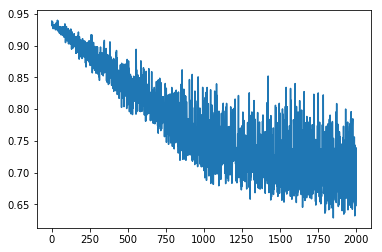

Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n

 11%|█         | 2/19 [07:10<1:00:51, 214.80s/it]

Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009232/mean_vggface2/n009114/epsilon_0.1/png
input images mean -8.830317588248704e-10 and stddev 1.0000001192092896
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275


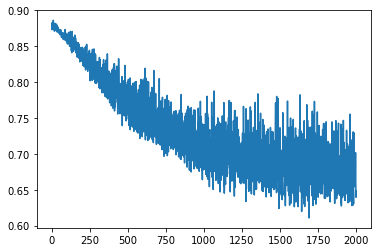

Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n

 16%|█▌        | 3/19 [10:44<57:12, 214.55s/it]  

Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000958/mean_vggface2/n

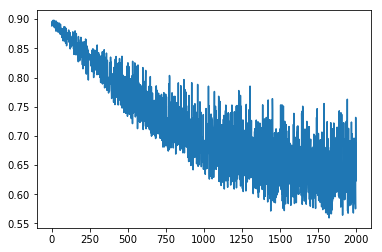

Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n

 21%|██        | 4/19 [14:20<53:46, 215.09s/it]

Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003356/mean_vggface2/n009114/epsilon_0.1/png
input images mean -1.2892264145136778e-08 and stddev 1.0000001192092896
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from 

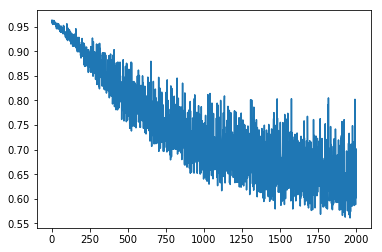

Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n008613/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n

 26%|██▋       | 5/19 [17:56<50:15, 215.40s/it]

Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008655/mean_vggface2/n009114/epsilon_0.1/png
input images mean 6.975950928023167e-09 and stddev 1.0000003576278687


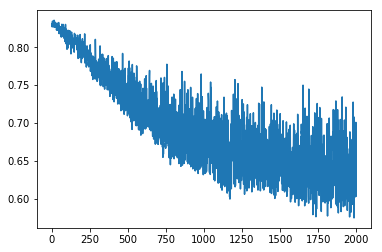

Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n

 32%|███▏      | 6/19 [21:34<46:48, 216.05s/it]

Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n008613/mean_vggface2/n

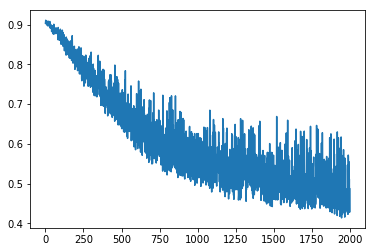

Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n

 37%|███▋      | 7/19 [25:07<43:01, 215.13s/it]

Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n004658/mean_vggface2/n

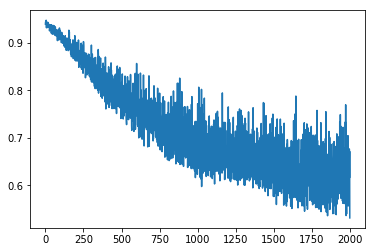

Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n

 42%|████▏     | 8/19 [28:40<39:21, 214.67s/it]

Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n002763/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n002503/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n002503/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n001683/mean_vggface2/n

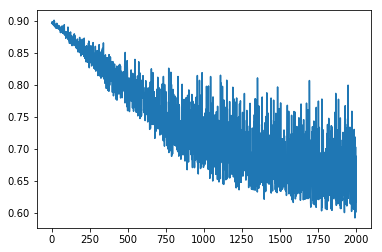

Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n

 47%|████▋     | 9/19 [32:18<35:55, 215.51s/it]

Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002647/mean_vggface2/n009114/epsilon_0.1/png
input images mean 2.0839550529672124e-08 and stddev 0.9999999403953552
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275


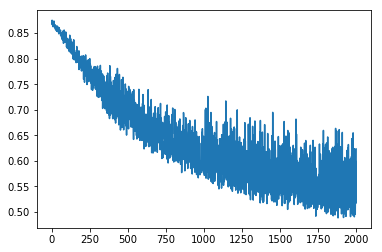

Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n

 53%|█████▎    | 10/19 [36:09<33:02, 220.28s/it]

Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009288/mean_vggface2/n

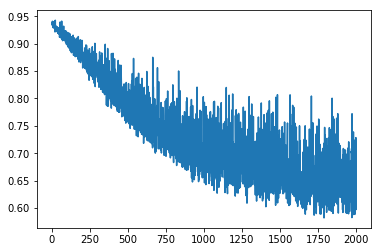

Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n

 58%|█████▊    | 11/19 [40:09<30:08, 226.04s/it]

Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005427/mean_vggface2/n

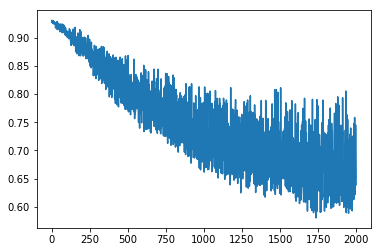

Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n

 63%|██████▎   | 12/19 [44:09<26:51, 230.17s/it]

Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002763/mean_vggface2/n

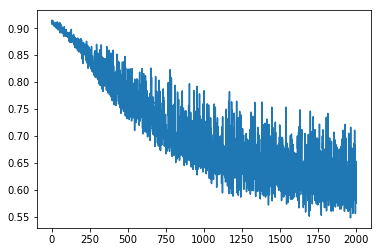

Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n

 68%|██████▊   | 13/19 [47:47<22:38, 226.50s/it]

Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n002503/mean_vggface2/n

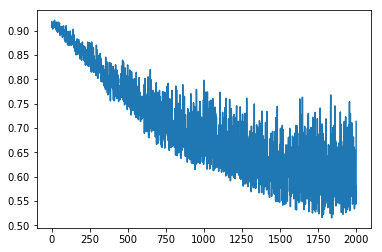

Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n

 74%|███████▎  | 14/19 [51:25<18:40, 224.13s/it]

Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n003215/mean_vggface2/n009114/epsilon_0.1/png
input images mean 1.3598689285743149e-08 and stddev 1.0000001192092896

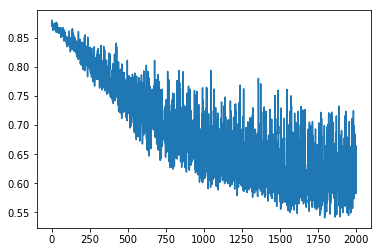

Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n

 79%|███████▉  | 15/19 [55:01<14:47, 221.80s/it]

Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n002503/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005359/mean_vggface2/n

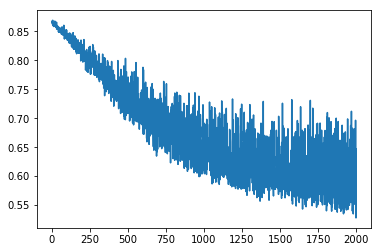

Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n

 84%|████████▍ | 16/19 [58:38<11:00, 220.17s/it]

Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n005303/mean_vggface2/n009114/epsilon_0.1/png
input images mean -2.781550101360608e-09 and stddev 0.9999998211860657
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275


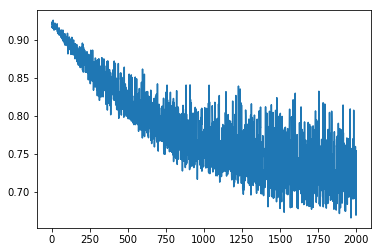

Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n

 89%|████████▉ | 17/19 [1:02:12<07:16, 218.41s/it]

Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n007548/mean_vggface2/n009114/epsilon_0.1/png
input images mean 5.121584489842235e-09 and stddev 0.9999999403953552
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275


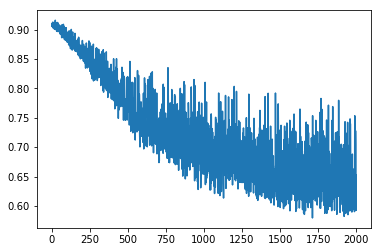

Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n

 95%|█████████▍| 18/19 [1:05:49<03:37, 217.83s/it]

Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n009114/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n000029/mean_vggface2/n009114/epsilon_0.1/png
input images mean -8.830317727026582e-11 and stddev 0.9999998211860657

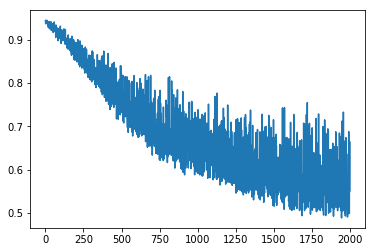

Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n001781/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n009232/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n000958/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n003356/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n008655/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n

100%|██████████| 19/19 [1:09:24<00:00, 219.19s/it]

Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n003215/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n005359/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n005303/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n007548/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n000029/epsilon_0.1/png
Saving to /data/vggface/test_perturbed_sampled/n009114/mean_vggface2/n000029/epsilon_0.1/png


In [12]:
generate_decoys_bigger_batches(
    people,
    "mean",
    "vggface2",
    0.01,
    0.1,
    2000
)

In [36]:
class FacialVectorsDatabase:
    def __init__(self, folder, model_name, epsilon, attack_strategy, image_format, num_clean):
        self.associated_identities = []
        self.vectors = []
        self.associated_paths = []
        
        identities = os.listdir(folder)
        
        
        self.graph = tf.Graph()
        
        with self.graph.as_default():
            self.model = build_model(model_name)

            for person_name in tqdm(identities):
                attack_subfolder = os.path.join(folder, person_name, attack_strategy)

                protected = os.listdir(attack_subfolder)
            
                for indx, other_identity in enumerate(protected):
                    protected_folder = os.path.join(
                        attack_subfolder, 
                        other_identity, 
                        "epsilon_{eps}".format(eps=epsilon), 
                        image_format
                    )

                    self._add_folder_for_person(
                        protected_folder, 
                        person_name,
                        exclude_endings=None,
                        max_imgs=-1
                    )
                # These were the images we used for this person for adversarial modification
                used_images = [
                    x.split("/")[-1] \
                    for indx, x in enumerate(self.associated_paths) \
                    if self.associated_identities[indx] == person_name
                ]
                
                clean_folder = os.path.join(
                    folder, person_name, "community_naive_mean", protected[0], "epsilon_0.0", "png")
                self._add_folder_for_person(
                    clean_folder, 
                    person_name,
                    exclude_endings=set(used_images),
                    max_imgs=num_clean
                )
        
                
    def _load_one_facenet(self, path, crop_box=None, resize_size=None, prewhiten_img=True):
        img = Image.open(path).convert("RGB")
        
        if crop_box:
            img = img.crop(crop_box)
            
        if resize_size:
            img = img.resize((resize_size, resize_size))
            
        img = (np.array(img)).astype(np.float32)
        
        if prewhiten_img:
            img = prewhiten(img)
            
        return img
        

    def _load_folder_for_facenet(self, folder, exclude_endings=None, max_imgs=-1):
        paths_list = glob.glob(os.path.join(folder, "*"))
        len_before = len(paths_list)
        if not (exclude_endings is None):
            paths_list = [x for x in paths_list if not (x.split("/")[-1] in exclude_endings)]
            
        if max_imgs > 0:
            paths_list = paths_list[:max_imgs]
        
        final_imgs = [
            self._load_one_facenet(
                img_path, 
                prewhiten_img=False, 
                resize_size=None, 
                crop_box=None) for img_path in paths_list
        ]

        final_imgs = np.array(final_imgs)
        final_imgs = prewhiten(np.array(final_imgs))
        return final_imgs, paths_list

    
    def _compute_embeddings(self, images):
        return l2_normalize(self.model.predict(np.array(images), batch_size=len(images)))
    
    
    def _add_folder_for_person(self, folder, person_name, exclude_endings=None, max_imgs=-1):
        images, paths_list = self._load_folder_for_facenet(folder, exclude_endings, max_imgs=max_imgs)
        
        if images is None:
            return
        
        vectors = self._compute_embeddings(images)
        self.vectors.extend(vectors)
        self.associated_identities.extend([person_name for _ in range(len(vectors))])
        self.associated_paths.extend(paths_list)
    
    def nearest_neighbor_to_img_at_path(self, query_path):
        with self.graph.as_default():
            query_vector = self._compute_embeddings(
                np.expand_dims(self._load_one_facenet(query_path, resize_size=160), axis=0))
        distances = pairwise_distances(query_vector, self.vectors, metric="cosine")[0]
        min_dist_indx = np.argmin(distances)
        return self.associated_identities[min_dist_indx], self.associated_paths[min_dist_indx]
    

def full_path_to_info(path):
    split = path.split("/")
    if path.startswith("/data/vggface/test_perturbed_sampled"):
        # split of path breaks down like this:
        #     0 
        #     1 data
        #     2 vggface
        #     3 test_perturbed_sampled
        #     4 {protector}
        #     5 community_naive_mean
        #     6 {protected}
        #     7 epsilon_0.0
        #     8 png
        #     9 35.png
        return "-".join([split[4], split[6], split[7], split[9]])
    else:
        # split of path breaks down like this:
        #     0 
        #     1 data
        #     2 vggface
        #     3 test_query_antisampled
        #     4 {protector}
        #     5 image_name.jpeg
        return "-".join([split[4], split[5]])
    
    
def measure_local_recall(
    faces_database,
    image_directory="/data/vggface/test_query_antisampled",
    num_query=10,
    verbose=False
):
    discovery = []
    true = []
    identified_as = []
    
    paths_of_query = []
    paths_of_nearest = []

    for protector in os.listdir(image_directory):
        # We are sourcing query photos from epsilon_0.0.
        # In those cases, all subfolders in the "protected" identity have the same, clean
        # photo of the protector, so we just pick any single one that exists (e.g. n000958)
        # For the case where n000958 is itself the protector, n000958 is not present in its protected
        # subfolders, so we pick n000029 without loss of generality.
        if protector == "n000958":
            protected = "n000029"
        else:
            protected = "n000958"

        query_photos_paths = sorted(glob.glob(
            os.path.join(image_directory, protector, "*")
        ))

        
        for i in np.random.choice(len(query_photos_paths), num_query):
            chosen_path = query_photos_paths[i]
            top_identity, top_identity_path = faces_database.nearest_neighbor_to_img_at_path(chosen_path)
            
            paths_of_query.append(full_path_to_info(chosen_path))
            paths_of_nearest.append(full_path_to_info(top_identity_path))
            
            true.append(protector)
            identified_as.append(top_identity)

            if top_identity == protector:
                discovery.append(1.0)
            else:
                discovery.append(0.0)

    if verbose:
        for true_id, recognized_id, query, nearest in zip(true, identified_as, paths_of_query, paths_of_nearest):
            print("Face of {true_id} identitifed as {recognized_id}. Nearest neighbor to {query} was {nearest}".format(
                true_id=true_id, recognized_id=recognized_id, query=query, nearest=nearest))
        
    return sum(discovery)/len(discovery)

In [ ]:
dataset_name = "vggface2"
faces_db = FacialVectorsDatabase(
    folder="/data/vggface/test_perturbed_sampled",
    model_name=dataset_name,
    epsilon=0.1,
    attack_strategy="mean_vggface2",
    image_format="png", 
    num_clean=2
)
print("Recall for model", dataset_name, 
      measure_local_recall(faces_db, num_query=10, verbose=True))
faces_db.model.sess.close()

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from /home/ivan/facenet/models/20180402-114759/model-20180402-114759.ckpt-275


 47%|████▋     | 9/19 [00:04<00:04,  2.35it/s]

In [ ]:
dataset_name = "casia-webface"
faces_db = FacialVectorsDatabase(
    folder="/data/vggface/test_perturbed_sampled",
    model_name=dataset_name,
    epsilon=0.1,
    attack_strategy="mean_vggface2",
    image_format="png"
)
print("Recall for model", dataset_name, 
      measure_local_recall(faces_db, num_query=10, verbose=True))
faces_db.model.sess.close()